In [1]:
%pip install pytorch-lightning

In [2]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['src', '.git', 'playground', 'reports', 'analysis', 'dct_mean_real_fake.png', 'faceforensics_download.py', 'freqnet_image.ipynb', 'hf_wdf.sh', 'run_jupyter.sh', 'setup', 'environment.yml', 'README.md', 'config.py', '__pycache__', '.gitignore', '.cache', 'xet', '.tmp', '.hf_datasets_tmp', 'samples']


In [3]:
import config
import numpy as np
from PIL import Image

In [4]:
# pytorch
import torch
import pytorch_lightning as L

In [5]:
# import local dependencies
from src.adapters.datasets.wilddeepfake import WildDeepfakeDataModule
from src.models.resnet import ResNetClassifier
from src.transforms.fusion import get_fused_transform

In [6]:
model_id = "dwt_rgb_resnet18"
model_checkpoint_dir = f"{proj_dir}/{config.CHECKPOINTS_DIR}/{model_id}"

In [7]:
seed = config.SEED

# Set seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# Determine device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [8]:
# define model
checkpoint = "lightning_logs/version_0/checkpoints/epoch=13-step=177520.ckpt"
deepfake_detector = ResNetClassifier.load_from_checkpoint(
    checkpoint_path=f"{model_checkpoint_dir}/{checkpoint}",
    in_channels=7,
    freeze_features=False,
    weights_only=False
    )

In [9]:
# Set the model to evaluation mode
deepfake_detector.eval()

ResNetClassifier(
  (model): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [28]:
# Get your transformation function
dwt_rgb_transforms = get_fused_transform()

# Load a new image and apply the transformations
new_image = Image.open("analysis/samples/fake/5.png")

transformed_input = dwt_rgb_transforms['test'](new_image)

# Add a batch dimension and move to the appropriate device
input_tensor = transformed_input.unsqueeze(0).to(device)

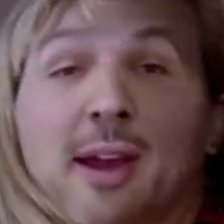

In [26]:
new_image

In [27]:
with torch.no_grad(): # Disable gradient calculations for faster inference
    output = deepfake_detector(input_tensor)

    # Apply sigmoid to convert logits to probabilities
    probabilities = torch.sigmoid(output)

    # Get the predicted class (0 for Real, 1 for Fake, depending on your setup)
    prediction = (probabilities > 0.5).long()

print(f"Output Logits: {output.item()}")
print(f"Probability of being Fake: {probabilities.item()}")
print(f"Predicted Class: {prediction.item()}")
print(f"Prediction: {"Fake" if prediction.item() == 1 else "Real"}")

Output Logits: 5.142584800720215
Probability of being Fake: 0.9941913485527039
Predicted Class: 1
Prediction: Fake
